In [1]:
import importlib
import pipeline
importlib.reload(pipeline)

from utils.metrics import Similarity, Uncertainty, UCAggregator
from utils.builders import GraphBuilder 
from utils.selection import Selector
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pipeline import GAL
from ref.ActiveLearning_OG import AL
from sklearn.linear_model import LogisticRegression

import pickle
np.random.seed(81)

c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
with open('data/lab_dataset.pkl', 'rb') as f:
	dataset = pickle.load(f)

In [3]:
dataset = dataset['data']

In [4]:
print(dataset['available_pool_labels'].shape)

(24990,)


In [5]:
train_size, pool_size, test_size = None, 2_000, 1_000

iterations = 100
budg_per = 20

In [6]:
n_pool = len(dataset['available_pool_samples'])
n_test = len(dataset['test_samples'])

In [7]:
pool_sample_idx = np.random.choice(range(n_pool), pool_size)
test_sample_idx = np.random.choice(range(n_test), test_size)

In [8]:
dataset['available_pool_samples'] = dataset['available_pool_samples'][pool_sample_idx]
dataset['available_pool_labels'] = dataset['available_pool_labels'][pool_sample_idx]

dataset["test_samples"] = dataset["test_samples"][test_sample_idx]
dataset["test_labels"] = dataset["test_labels"][test_sample_idx]

# dataset['available_pool_samples'] = dataset['available_pool_samples'][:pool_size]
# dataset['available_pool_labels'] = dataset['available_pool_labels'][:pool_size]

# dataset["test_samples"] = dataset["test_samples"][:test_size]
# dataset["test_labels"] = dataset["test_labels"][:test_size]

In [10]:
al = GAL(dataset,
		 LogisticRegression(),
		 budg_per,
		 uncertainty_measures=['entropy_e',
						 'density_kmean',
						 'pagerank',
						 'area_variance',],
		 iterations=iterations,
		 gnn_epochs=20,
		 quantile=.01,
		 labels=4,
		 coef=[True, True, False, False],
		 )
res_gal = al.run(plot=False)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 100/100 [00:13<00:00,  7.46it/s, GAL_Iteration=99, GAL_Accuracy=0.694, GAL_LR test acc=0.694]


In [11]:
selection_criteria = ['random', 'custom']
accuracy_scores_dict = {}
for criterion in selection_criteria:
	AL_class = AL(dataset=dataset,
			   selection_criterion=criterion,
			   iterations=iterations,
			   budget_per_iter=budg_per,
			   train_limit=int(1e6))
	accuracy_scores_dict[criterion] = AL_class.run_pipeline()


Iteration 1/100
Accuracy: 0.571
----------------------------------------
Iteration 2/100
Accuracy: 0.623
----------------------------------------
Iteration 3/100
Accuracy: 0.666
----------------------------------------
Iteration 4/100
Accuracy: 0.657
----------------------------------------
Iteration 5/100
Accuracy: 0.67
----------------------------------------
Iteration 6/100
Accuracy: 0.667
----------------------------------------
Iteration 7/100
Accuracy: 0.674
----------------------------------------
Iteration 8/100
Accuracy: 0.682
----------------------------------------
Iteration 9/100
Accuracy: 0.688
----------------------------------------
Iteration 10/100
Accuracy: 0.692
----------------------------------------
Iteration 11/100
Accuracy: 0.69
----------------------------------------
Iteration 12/100
Accuracy: 0.693
----------------------------------------
Iteration 13/100
Accuracy: 0.683
----------------------------------------
Iteration 14/100
Accuracy: 0.687
----------------

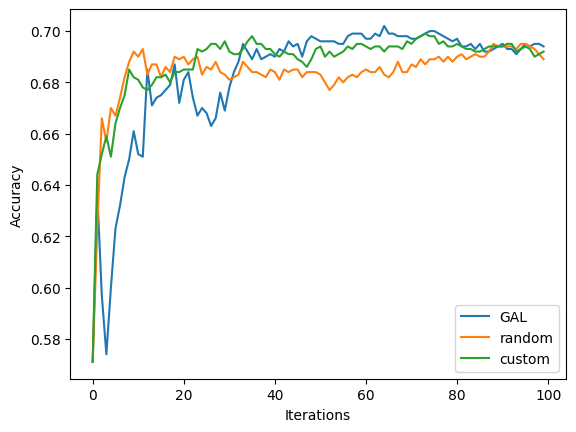

In [12]:
if al.use_gnn:
	plt.plot(res_gal['aggr'], label='GAL')
	plt.plot(res_gal['GNN'], label='GNN', alpha=.5)
	plt.plot(res_gal['LR'], label='LR', alpha=.5)
else:
	plt.plot(res_gal, label='GAL')

for criterion, accuracy_scores in accuracy_scores_dict.items():
	plt.plot(accuracy_scores, label=criterion)
	# plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
# plt.xticks(range(1, len(accuracy_scores) + 1))
plt.legend()
plt.show()
